# Audio Deepfake Detection — End-to-End Experimental Pipeline

This notebook runs the full pipeline: **paths** → **(optional) feature extraction** → **load features** → **train on FoR** → **evaluate on FoR test** → **zero-shot** on ITW / ElevenLabs (if available) → **optional save**.

Other model notebooks:
[`XGBoost.ipynb`](./XGBoost.ipynb),
[`random_forest.ipynb`](./random_forest.ipynb),
[`DT.ipynb`](./DT.ipynb),
[`Linear_SVM.ipynb`](./Linear_SVM.ipynb),
[`model_zero_shot_evaluation.ipynb`](./model_zero_shot_evaluation.ipynb).


## 0. Feature extraction
First, the audio files were examined to verify the sample rate and number of channels. This process is documented in [`audiofile_exploration.ipynb`](./audiofile_exploration.ipynb). The sample rate is 16 kHz, and all files are single-channel (mono).
Run only if you have raw FoR WAVs and want to (re)build parquet. Set `RUN_FEATURE_EXTRACTION = True`. Otherwise use pre-built parquet under `FoR_dataset/features/`.

In [ ]:
RUN_FEATURE_EXTRACTION = False

if RUN_FEATURE_EXTRACTION:
    import pandas as pd
    import os
    from configs.config import PROJECT_ROOT
    from configs.config import DATASET_PATH
    from data_preprocessing.feature_extraction import extract_features_from_folder

    N_MFCC, N_FFT, HOP_LENGTH, N_MELS = 20, 128, 256, 128
    feature_config = {
        "rmse": {}, "zero_crossing_rate": {}, "spectral_centroid": {}, "spectral_bandwidth": {},
        "spectral_flatness": {}, "spectral_rolloff": {},
        "mfcc": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "mfcc_delta": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "mfcc_delta2": {"n_mfcc": N_MFCC, "n_fft": N_FFT, "hop_length": HOP_LENGTH},
        "pitch_yin": {"fmin": 50, "fmax": 300},
        "mel_spectrogram": {"n_mels": N_MELS},
    }
    for split in ["training", "validation", "testing"]:
        folder = os.path.join(DATASET_PATH, split)
        if not os.path.isdir(folder):
            continue
        df = extract_features_from_folder(folder, feature_config, sample_rate=16000)
        out = os.path.join(PROJECT_ROOT, "FoR_dataset", "features", f"{split}_features_mean_{N_MFCC}_{N_FFT}_{HOP_LENGTH}_{N_MELS}.parquet")
        df.to_parquet(out, index=False)
        print(f"Saved {out}")
else:
    print("Skipping feature extraction (RUN_FEATURE_EXTRACTION=False). Use pre-built parquet.")

Skipping feature extraction (RUN_FEATURE_EXTRACTION=False). Use pre-built parquet.


## Audio Normalization and Trimming of the In-The-Wild Dataset

During data exploration of the two datasets ([`itw_data_exploration.ipynb`](./itw_data_exploration.ipynb), [`itw_normalization.ipynb`](./itw_normalization.ipynb)) we saw a loudness mismatch between the FoR training data and the In-The-Wild (ITW) set. Specifically:

- **FoR** files are normlized and show around **-15 to -18 LUFS** (std ~2 LUFS).
- **ITW** files are quieter, averaging **-26 to -29 LUFS** with higher variance (std ~4-6 LUFS).

To avoid potential bias, we applied loudness normalization to the ITW audio files using ffmpeg's `loudnorm` filter, bringing them to a target of **-15.0 LUFS**. Features were then re-extracted from the normalized audio and stored as separate parquet files (e.g. `itw_features_*_trimmed_loudness_normalized.parquet`).

The full normalization pipeline and before/after LUFS statistics are documented in [`itw_normalization.ipynb`](./itw_normalization.ipynb).

## 1. Setup and paths

In [2]:
import os
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

from configs.config import (
    FEATURES_DIR,
    ITW_DATASET_PATH,
    ELEVEN_LABS_FEATURES_PATH,
    MODELS_PATH,
)

FEATURE_SET = "mean_20_128_256_128"
train_path = os.path.join(FEATURES_DIR, f"training_features_{FEATURE_SET}.parquet")
val_path = os.path.join(FEATURES_DIR, f"validation_features_{FEATURE_SET}.parquet")
test_path = os.path.join(FEATURES_DIR, f"testing_features_{FEATURE_SET}.parquet")

itw_features_path = os.path.join(ITW_DATASET_PATH, "normalized_features", f"itw_features_{FEATURE_SET}_trimmed_loudness_normalized.parquet")
eleven_features_path = os.path.join(ELEVEN_LABS_FEATURES_PATH, f"eleven_labs_features_{FEATURE_SET}.parquet")

for name, p in [("train", train_path), ("val", val_path), ("test", test_path)]:
    print(f"FoR {name}: {'OK' if os.path.isfile(p) else 'MISSING'} — {p}")
for name, p in [("ITW", itw_features_path), ("ElevenLabs", eleven_features_path)]:
    print(f"{name}: {'OK' if os.path.isfile(p) else 'MISSING'} — {p}")

FoR train: OK — c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\training_features_mean_20_128_256_128.parquet
FoR val: OK — c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\validation_features_mean_20_128_256_128.parquet
FoR test: OK — c:\Users\geon9\MSc\audio-deepfake-detection\FoR_dataset\features\testing_features_mean_20_128_256_128.parquet
ITW: OK — c:\Users\geon9\MSc\audio-deepfake-detection\in-the-wild-audio-deepfake\normalized_features\itw_features_mean_20_128_256_128_trimmed_loudness_normalized.parquet
ElevenLabs: OK — c:\Users\geon9\MSc\audio-deepfake-detection\elevenlabs-dataset\features\eleven_labs_features_mean_20_128_256_128.parquet


## 2. Load data and train

In [5]:
from utils.utils import (
    train_and_evaluate_linear_svm,
    evaluate_model_on_parquet,
    save_experiment,
)

pipeline, metrics, model_params, feature_names, metadata_extra = train_and_evaluate_linear_svm(
    train_path=train_path,
    test_path=test_path,
    svc_params={"C": 1.0, "class_weight": {0:1, 1:5}, "max_iter": 20000, "random_state": 42},
)

print("FoR test metrics:", metrics)
print("Train/test samples:", metadata_extra)

FoR test metrics: {'accuracy': 0.7037116961588261, 'precision': 0.7702881438639639, 'recall': 0.6978917863159935, 'f1': 0.6803406882062135, 'roc_auc': 0.8796169357844672}
Train/test samples: {'train_samples': 53864, 'test_samples': 4634}


## 3. Evaluate on FoR test (with plots)

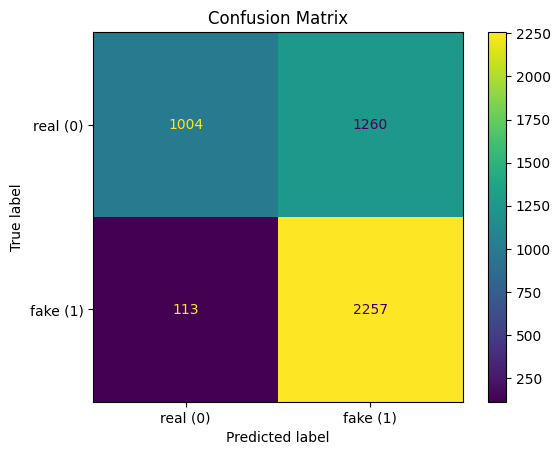

FoR test: {'accuracy': 0.7037116961588261, 'precision': 0.6417401194199602, 'recall': 0.9523206751054852, 'f1_macro': 0.6803406882062135, 'roc_auc': 0.8796037035380417}


In [10]:
metrics_for, meta_for = evaluate_model_on_parquet(pipeline, test_path, plots=True)
print("FoR test:", metrics_for)

## 4. Zero-shot evaluation (ITW and ElevenLabs)

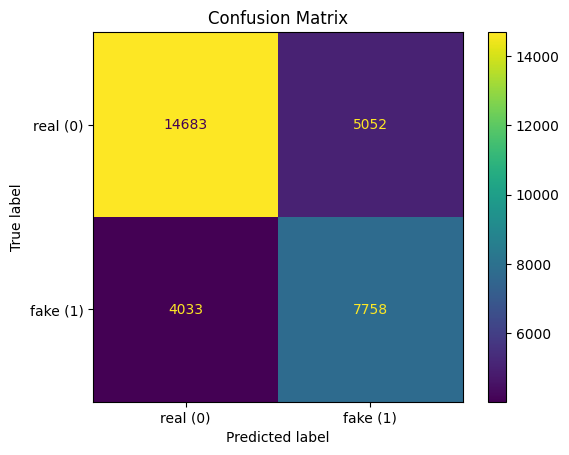

In-the-Wild: {'accuracy': 0.7118251601852439, 'precision': 0.6056206088992975, 'recall': 0.6579594606055466, 'f1_macro': 0.6972156647902136, 'roc_auc': 0.7640477442214852}


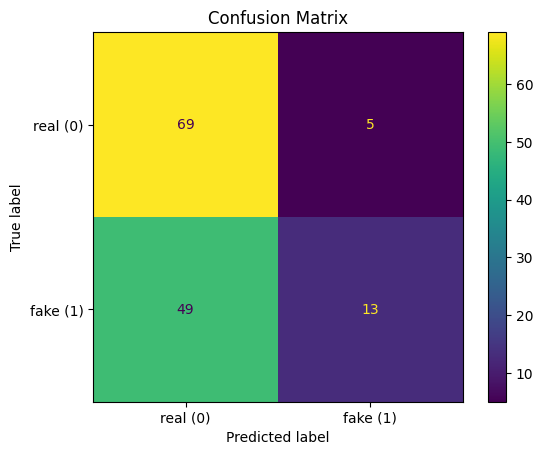

ElevenLabs: {'accuracy': 0.6029411764705882, 'precision': 0.7222222222222222, 'recall': 0.20967741935483872, 'f1_macro': 0.521875, 'roc_auc': 0.6924585876198781}


In [11]:
if os.path.isfile(itw_features_path):
    metrics_itw, _ = evaluate_model_on_parquet(pipeline, itw_features_path, plots=True)
    print("In-the-Wild:", metrics_itw)
else:
    print("ITW features not found, skipping.")

if os.path.isfile(eleven_features_path):
    metrics_eleven, _ = evaluate_model_on_parquet(pipeline, eleven_features_path, plots=True)
    print("ElevenLabs:", metrics_eleven)
else:
    print("ElevenLabs features not found, skipping.")

## Zero Shot Evaluation Using XGBoost's best model

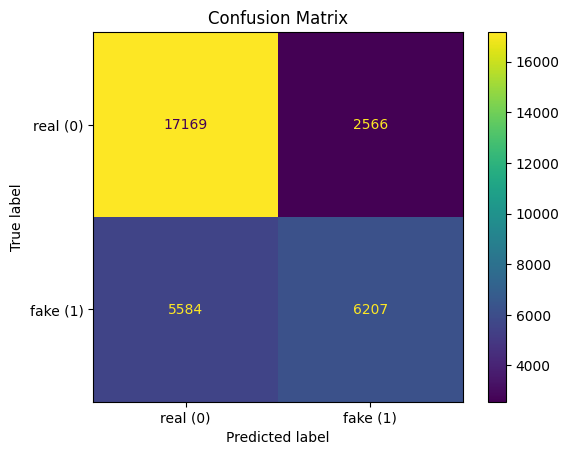

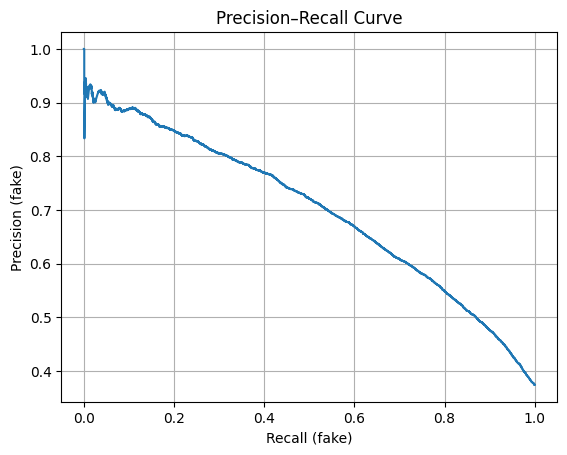

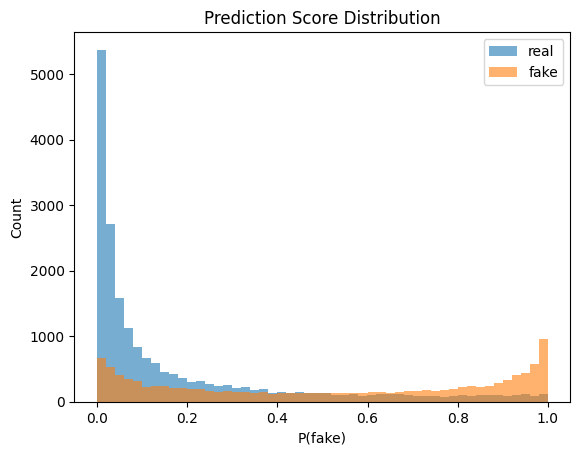

In-the-Wild: {'accuracy': 0.7414832201992007, 'precision': 0.7075116835746039, 'recall': 0.5264184547536257, 'f1_macro': 0.7059287305296238, 'roc_auc': 0.7857108124426275}


c:\Users\geon9\MSc\audio-deepfake-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


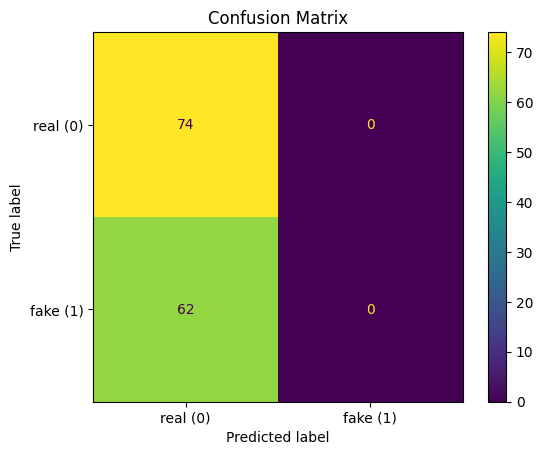

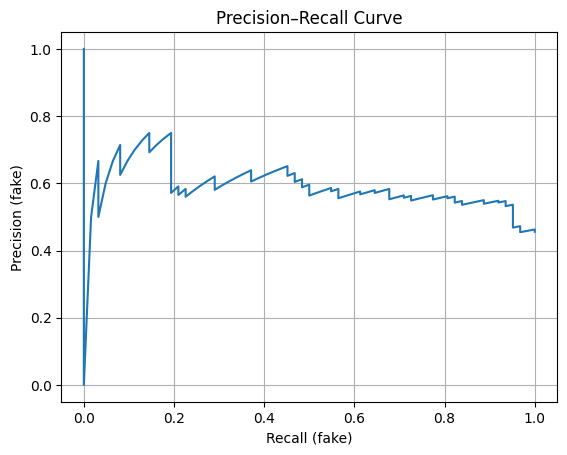

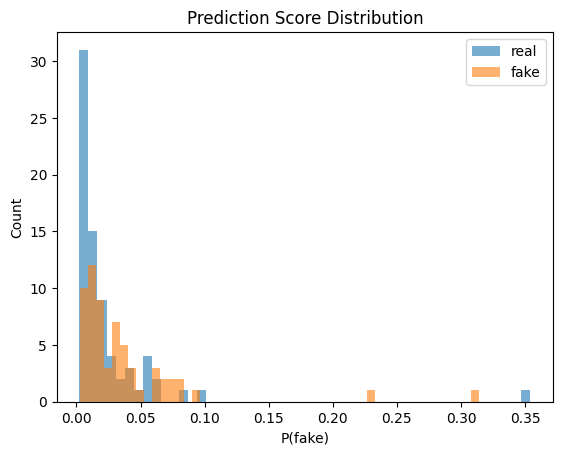

ElevenLabs: {'accuracy': 0.5441176470588235, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.3523809523809524, 'roc_auc': 0.6719703574542285}


In [8]:

import joblib 
xgboost_no_mel_model = os.path.join("experiments", "final", "XGB_NO_MEL", "exp_20260208_034900", "model.joblib")
itw_no_mel_path = os.path.join(ITW_DATASET_PATH, "normalized_features", 
    "itw_features_mean_20_128_256_128_no_mel_trimmed_loudness_normalized.parquet")

eleven_no_mel_path = os.path.join(ELEVEN_LABS_FEATURES_PATH, 
                                  "eleven_labs_features_mean_20_128_256_128_no_mel.parquet")

model = joblib.load(xgboost_no_mel_model)

if os.path.isfile(itw_features_path):
    metrics_itw, _ = evaluate_model_on_parquet(model, itw_no_mel_path, plots=True)
    print("In-the-Wild:", metrics_itw)
else:
    print("ITW features not found, skipping.")

if os.path.isfile(eleven_features_path):
    metrics_eleven, _ = evaluate_model_on_parquet(model, eleven_no_mel_path, plots=True)
    print("ElevenLabs:", metrics_eleven)
else:
    print("ElevenLabs features not found, skipping.")

## 5. Optional: save experiment

In [12]:
save_experiment(
    pipeline,
    metrics,
    experiment_dir=MODELS_PATH,
    experiment_name="linear_svm",
    model_params=model_params,
    feature_names=feature_names,
    metadata_extra=metadata_extra,
)

Experiment saved to: /app/notebooks/experiments/linear_svm


'/app/notebooks/experiments/linear_svm'